# PARAMETRIC ELLIPTIC OPTIMAL CONTROL

# Import di tutti i pacchetti

In [1]:
nome = 'nome' #Nome che voglio dare alla simulazione così da distinguere loss e plot per tutto

import argparse
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.nn import Softplus

#Questo serve a fare in modo che tutti i problemi abbiano come riferimento la stessa cartella di PINA
#così non si creano versioni diverse o sovrapposizioni
import sys
sys.path.append('C:/Users/Andrea/Desktop/Poli/Tesi magistrale/reporitory_SISSA_PoliTO')

from pina import LabelTensor
from pina.solvers import PINN
from pina.model import MultiFeedForward
from pina.plotter import Plotter
from pina.trainer import Trainer
from pina.model import FeedForward
from pina.callbacks import MetricTracker

from pina import Condition
from pina.geometry import CartesianDomain
from pina.equation import SystemEquation, FixedValue
from pina.problem import SpatialProblem, ParametricProblem
from pina.operators import laplacian

# Definizione del problema
Il problema di base ha due parametri che sono 
- $\mu\in[0.5, 3]$ 
- $\alpha\in[0.01,1]$

In [2]:
# ===================================================== #                                        
#           u --> field variable                        #
#           p --> field variable                        #
#           y --> field variable                        #
#           x1, x2 --> spatial variables                #
#           mu, alpha --> problem parameters            #
#                                                       #
#           https://arxiv.org/pdf/2110.13530.pdf        #                         
# ===================================================== #


class ParametricEllipticOptimalControl(SpatialProblem, ParametricProblem):

    # setting spatial variables ranges
    xmin, xmax, ymin, ymax = -1, 1, -1, 1
    x_range = [xmin, xmax]
    y_range = [ymin, ymax]
    # setting parameters range
    amin, amax = 0.01, 1
    mumin, mumax = 0.5, 3
    mu_range = [mumin, mumax]
    a_range = [amin, amax]
    # setting field variables
    output_variables = ['u', 'y', 'p']
    # setting spatial and parameter domain
    spatial_domain = CartesianDomain({'x1': x_range, 'x2': y_range})
    parameter_domain = CartesianDomain({'mu': mu_range, 'alpha': a_range})

    # equation terms as in https://arxiv.org/pdf/2110.13530.pdf
    def term1(input_, output_):
        laplace_p = laplacian(output_, input_, components=['p'], d = ['x1', 'x2'])
        return output_.extract(['y']) - input_.extract(['mu']) - laplace_p

    def term2(input_, output_):
        laplace_y = laplacian(output_, input_, components=['y'], d = ['x1', 'x2'])
        return - laplace_y - output_.extract(['u'])
    
    def fixed_y(input_, output_):
        return output_.extract(['y'])

    def fixed_p(input_, output_):
        return output_.extract(['p']) 

    # setting problem condition formulation
    conditions = {
        'gamma1': Condition(
            location=CartesianDomain({'x1': x_range, 'x2':  1, 'mu': mu_range, 'alpha': a_range}),
            equation=SystemEquation([fixed_y, fixed_p])),
        'gamma2': Condition(
            location=CartesianDomain({'x1': x_range, 'x2': -1, 'mu': mu_range, 'alpha': a_range}),
            equation=SystemEquation([fixed_y, fixed_p])),
        'gamma3': Condition(
            location=CartesianDomain({'x1':  1, 'x2': y_range, 'mu': mu_range, 'alpha': a_range}),
            equation=SystemEquation([fixed_y, fixed_p])),
        'gamma4': Condition(
            location=CartesianDomain({'x1': -1, 'x2': y_range, 'mu': mu_range, 'alpha': a_range}),
            equation=SystemEquation([fixed_y, fixed_p])),
        'D': Condition(location = CartesianDomain({'x1': x_range, 'x2': y_range, 'mu': mu_range, 'alpha': a_range}), equation=SystemEquation([term1, term2])),
    }

# DEFINIZIONE ARCHITETTURA DELLA PINN

In [3]:
#EXTRA FEATURE
class myFeature(torch.nn.Module):
    """
    Feature: sin(x)
    """

    def __init__(self):
        super(myFeature, self).__init__()

    def forward(self, x):
        t = (-x.extract(['x1'])**2+1) * (-x.extract(['x2'])**2+1)
        return LabelTensor(t, ['k0'])


#FORWARD
class CustomMultiDFF(MultiFeedForward):

    def __init__(self, dff_dict):
        super().__init__(dff_dict)

    #Original forward
    def forward(self, x):
        out = self.uu(x)
        out.labels = ['u', 'y']
        p = LabelTensor((out.extract(['u']) * x.extract(['alpha'])), ['p'])
        
        return out.append(p)

In [4]:
if __name__ == "__main__":
    
    seed = 316680
    torch.manual_seed(seed)
    
    epochs = 100
    flag_extra_feature = 1
    
    parser = argparse.ArgumentParser(description = "Run PINA")
    parser.add_argument("--load", help = "directory to save or load file", type = str)
    parser.add_argument("--features", help = "extra features", type = int, default = flag_extra_feature)
    parser.add_argument("--epochs", help = "extra features", type = int, default = epochs)
    parser.add_argument('-f') #Serve per risolvere l'errore di sotto
    args = parser.parse_args()
    
    if args.features is None:
        args.features = 0
    
    # extra features
    feat = [myFeature()] if args.features else []
    args = parser.parse_args()
    
    # create problem and discretise domain
    opc = ParametricEllipticOptimalControl()
    opc.discretise_domain(n = 1, mode='random', variables = ['x1', 'x2'], locations = ['D'])
    opc.discretise_domain(n = 1, mode='random', variables = ['mu', 'alpha'], locations = ['D'])
    opc.discretise_domain(n = 1, mode='random', variables = ['x1', 'x2'], locations = ['gamma1', 'gamma2', 'gamma3', 'gamma4'])
    opc.discretise_domain(n = 1, mode='random', variables = ['mu', 'alpha'], locations = ['gamma1', 'gamma2', 'gamma3', 'gamma4'])

    # Architettura
    model = CustomMultiDFF( 
        {
            'uu': {
                'input_dimensions': 4 + len(feat),  #due input spaziali più due parametri
                'output_dimensions': 2,
                'layers': [40, 40, 20],
                'func': Softplus,
            },
        }
    )    
    
    # Creazione dell''stanza di PINN
    pinn = PINN(problem = opc, model = model, optimizer_kwargs = {'lr' : 0.01}, extra_features = feat, scheduling = 0)
    
    # Creazione di istanza di Trainer
    directory = 'pina.parametric_optimal_control_{}'.format(bool(args.features))
    trainer = Trainer(solver = pinn, accelerator='cpu', max_epochs = args.epochs, default_root_dir = directory)
    
    # callbacks = [MetricTracker()] questo si può usare solo se ho abbastanza spazio, è molto pesante, serve per plottare la loss
    #trainer.solver.learning_rates #questo comando serve per vedere tutti i learning rate
    
    #Training
    trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Andrea\anaconda3\envs\PINA2\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name        | Type    | Params
----------------------------------------
0 | _loss       | MSELoss | 0     
1 | _neural_net | Network | 2.7 K 
----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s, v_num=24, gamma1_loss=0.000237, gamma2_loss=0.000378, gamma3_loss=0.000331, gamma4_loss=0.000188, D_loss=5.48e-6, mean_loss=0.000228]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s, v_num=24, gamma1_loss=0.000237, gamma2_loss=0.000378, gamma3_loss=0.000331, gamma4_loss=0.000188, D_loss=5.48e-6, mean_loss=0.000228]


# GRAFICI

In [17]:
plotter = Plotter()
plotter.plot(pinn, fixed_variables={'mu': 3, 'alpha': 1}, components='u', filename = nome + '_u.pdf')

In [7]:
plotter = Plotter()
plotter.plot(pinn, fixed_variables={'mu': 3, 'alpha': 1}, components='y', filename = nome + '_y.pdf')

In [8]:
plotter = Plotter()
plotter.plot(pinn, fixed_variables={'mu': 3, 'alpha': 1}, components='p', filename = nome + '_p.pdf')

# Loss

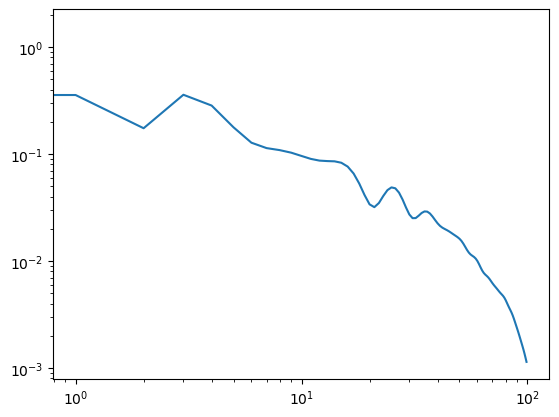

In [5]:
#Qui salvo la loss function
andamento_loss = trainer._model.lossVec
def salva_variabile(file, variabile):
    with open(file, 'w') as f:
        f.write(repr(variabile))

# Chiama la funzione per salvare la variabile
salva_variabile('loss_'+ nome +'.txt', andamento_loss) #Qui per salvare la loss

# Grafico loss
plt.loglog(andamento_loss)
plt.gcf().savefig(nome + 'grafico_loss.pdf', format='pdf') # Qui per salvare il grafico della loss